In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'ray_tracing_synthesis')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
torch.use_deterministic_algorithms(True)

from model_TimeShift_input_disable_norm import build_net
from utils import remove_blind_region_psf0, remove_blind_region_psf7p5, remove_blind_region_minuspsf7p5

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
import time
from time import sleep
from PIL import Image

from ray_tracing_synthesis import SoSToTimeShiftTransformer, image_to_sos_map



PARAM_SOS_BEAMFORMING = 1540
PARAM_SCALING_INPUT = 100000000
PARAM_SCALING_OUTPUT = 100
PARAM_BASE_OUTPUT = PARAM_SOS_BEAMFORMING
PARAM_NUMBER_OF_TRAINING_DATA = 1280000
PARAM_LEARNING_RATE = 0.0005
PARAM_WEIGHTDECAY = 0.3
EPOCH_NUM = 3
BATCH_SIZE = 32
GPU_BASE = 4
GPU_LIST_TO_PARALLEL = [GPU_BASE, 1,2,3] ### Specify the available GPU indices in your machine 
from worker_module import preparing_training_data  # <--- This is your external worker


data_parent_dir = (
    '/data/burg/sos_imaging/Delta_workspace/Final_Files_from_Delta_9_30/'
    'hc19/jupyter_dir/SoSMap_on_phase_shift/pretrained_w_natural_image/untar_ImageNet_6_1/'
)

def eval_testingdata(model, test_data, test_label, criterion):
    outputs = (
        model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
        [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
        + PARAM_BASE_OUTPUT
    )
    loss = criterion(outputs, test_label.to(f"cuda:{GPU_BASE}", dtype=torch.float))
    print("RMSE in testing set is", torch.sqrt(loss.cpu()).detach().numpy())



import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# Prepare test data
transformer = SoSToTimeShiftTransformer()
sos_from_ImageNet = []
time_lag_from_ImageNet = []
for i in range(1280001, 1280201):
    image = Image.open(f"{data_parent_dir}grayscale_cropped_{i}.JPEG")
    sos_map = image_to_sos_map(image)
    time_lag_from_ImageNet.append([
        remove_blind_region_psf7p5(transformer.transform(sos_map, "7p5psf")),
        remove_blind_region_psf0(transformer.transform(sos_map, "0psf")),
        remove_blind_region_minuspsf7p5(transformer.transform(sos_map, "minus7p5psf")),
    ])
    sos_from_ImageNet.append(sos_map[:, 19:-19])

test_data = torch.tensor(np.array(time_lag_from_ImageNet))
test_label = torch.tensor(np.array(sos_from_ImageNet)).unsqueeze(1)
del sos_from_ImageNet, time_lag_from_ImageNet





Class initializing, device is cuda


In [53]:
def visualize_test_data():
    fig, axs = plt.subplots(2, 6, figsize=(16, 6))
    outputs_test = (
            model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
            [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
            + PARAM_BASE_OUTPUT
        ).cpu().detach().numpy()

    for i in range(2):
        for j in range(6):
            # Example: Plot a sine wave with a different phase in each subplot
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + (i * 4 + j))
            if i == 0:
                im = axs[i, j].imshow(test_label[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Ground Truth")
            if i == 1:
                im = axs[i, j].imshow(outputs_test[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Reconstructed")
            # axs[i, j].plot(x, y)
            # axs[i, j].set_title(f"Plot ({i+1}, {j+1})")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            cbar = fig.colorbar(im, ax=axs[i, j])
            cbar.set_label("SoS [m/s]",fontsize = 13)

    plt.tight_layout()
    plt.show()

Elapsed time = 11.219882011413574
batch 1 / 40000
running_loss = 4880.31298828125
batch_loss = 5071.92431640625
queue length = 86
RMSE in testing set is 63.05142


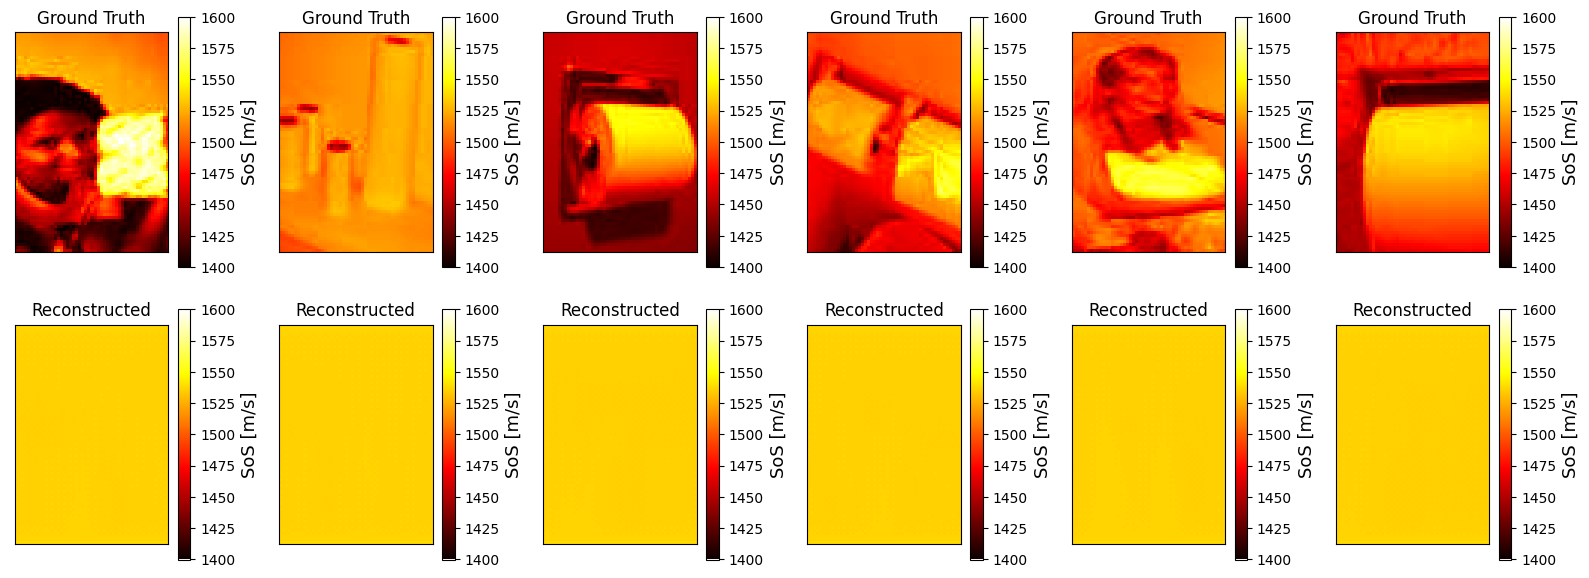

Elapsed time = 915.6920626163483
batch 5001 / 40000
running_loss = 950.4318939233389
batch_loss = 711.5386352539062
queue length = 16
RMSE in testing set is 22.382038


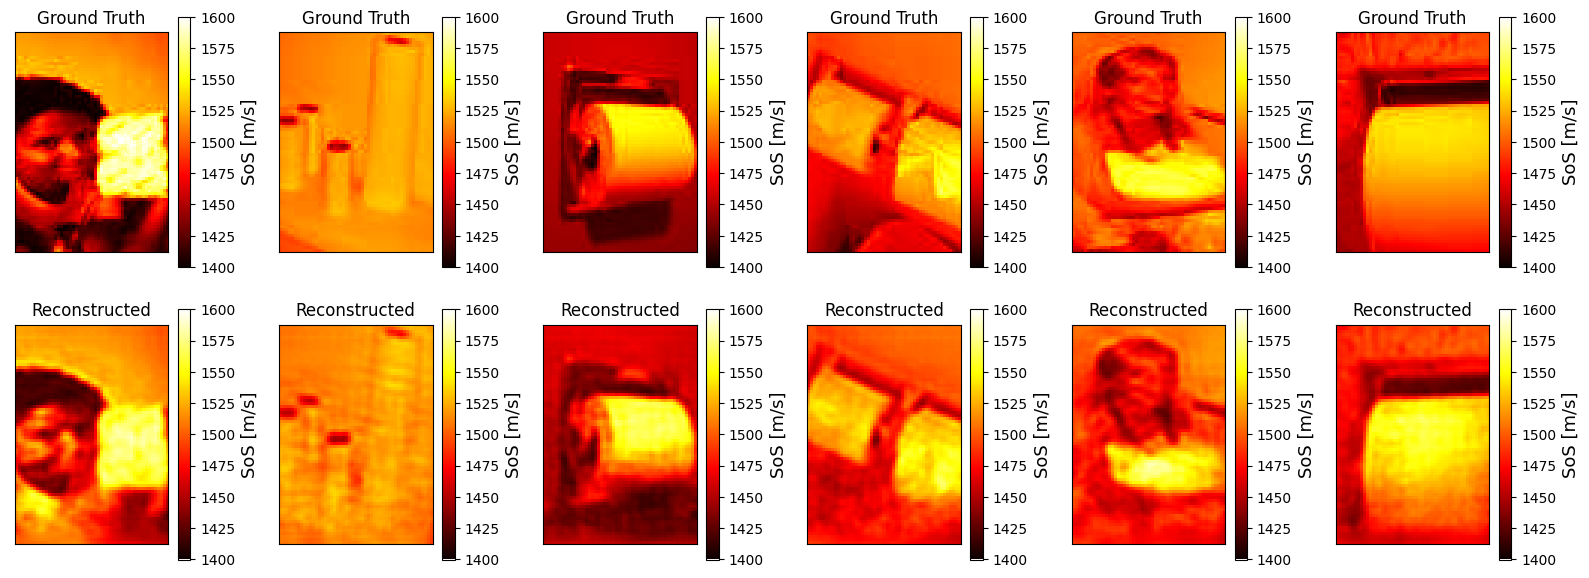

In [ ]:
model = build_net().to(f"cuda:{GPU_BASE}")
model = nn.DataParallel(model, device_ids=GPU_LIST_TO_PARALLEL)
model.train()

for m in model.modules():
    for child in m.children():
        if isinstance(child, nn.BatchNorm2d):
            child.track_running_stats = False
            child.running_mean = None
            child.running_var = None

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAM_LEARNING_RATE, weight_decay=PARAM_WEIGHTDECAY)

manager = mp.Manager()
shared_queue_time_lag = manager.list()
shared_lock_1, shared_lock_2 = mp.Lock(), mp.Lock()
idx_list_init = list(range(PARAM_NUMBER_OF_TRAINING_DATA))
random.shuffle(idx_list_init)
img_idx_tobe_loaded = manager.list(idx_list_init)


processes = [
    mp.Process(
        target=preparing_training_data,
        args=(
            shared_lock_1,
            shared_lock_2,
            img_idx_tobe_loaded,
            shared_queue_time_lag,
            PARAM_NUMBER_OF_TRAINING_DATA,
            4000,
            data_parent_dir,  # <--- Pass the data dir to the worker
        ),
    )
    for _ in range(4)
]
for p in processes:
    p.start()
    sleep(1)

LEN_TRAINING_DATA = PARAM_NUMBER_OF_TRAINING_DATA
last_time_stamp = time.time()
for epoch_i in range(EPOCH_NUM):
    running_loss = 0.0
    for batch_i in range(LEN_TRAINING_DATA // BATCH_SIZE):
        batch_data_np, batch_label_np = [], []
        for _ in range(BATCH_SIZE):
            while len(shared_queue_time_lag) == 0:
                sleep(1)
            time_lag_np, sos_np = shared_queue_time_lag.pop()
            batch_data_np.append(time_lag_np * PARAM_SCALING_INPUT)
            batch_label_np.append(sos_np)

        batch_data = torch.from_numpy(np.stack(batch_data_np)).to(f"cuda:{GPU_BASE}", dtype=torch.float)
        batch_label = torch.from_numpy(np.stack(batch_label_np)).unsqueeze(1).to(f"cuda:{GPU_BASE}", dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(
            outputs[:, :, :, 19:-19] * PARAM_SCALING_OUTPUT + PARAM_BASE_OUTPUT,
            batch_label[:, :, :, 19:-19],
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_i % 5000 == 1:
            print("Elapsed time =", time.time() - last_time_stamp)
            last_time_stamp = time.time()
            print(f"batch {batch_i} / {LEN_TRAINING_DATA // BATCH_SIZE}")
            print("running_loss =", running_loss / (batch_i + 1))
            print("batch_loss =", loss.item())
            print("queue length =", len(shared_queue_time_lag))

            from datetime import datetime
            current_date = datetime.now().strftime("%Y_%m_%d")
            ckpt_name = (
                f"./pre_trained_model_d{current_date}_parametric_3_input_beamforming_SoS_"
                f"{PARAM_SOS_BEAMFORMING}_output_base_{PARAM_BASE_OUTPUT}_NumberOfTraningData_"
                f"{PARAM_NUMBER_OF_TRAINING_DATA}_learning_rate_{PARAM_LEARNING_RATE}_"
                f"PARAM_WEIGHTDECAY_{PARAM_WEIGHTDECAY}_no_batch_norm.pt"
            )
            torch.save(model.module.state_dict(), ckpt_name)
            model.eval()
            eval_testingdata(model, test_data, test_label, criterion)
            visualize_test_data()
            model.train()

    print(f"Epoch {epoch_i + 1}/{EPOCH_NUM} finished. "
          f"Average loss: {running_loss / (LEN_TRAINING_DATA / BATCH_SIZE)}")
